## Step 0: Install prerequisites

In [1]:
# Install required packages
!pip install kaggle torch torchvision transformers pandas numpy matplotlib opencv-python scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [28]:
# Import necessary packages
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import random
import zipfile
import pandas as pd
from transformers import ViTConfig, ViTModel
from sklearn.metrics import average_precision_score
from google.colab import drive
from google.colab import files

In [27]:
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Download RAF-DB dataset from Kaggle

In [3]:
# Download RAF-DB dataset from Kaggle
def download_raf_db_from_kaggle():
    print("Please upload your kaggle.json file (download from Kaggle account settings):")
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Downloading RAF-DB dataset from Kaggle...")
    !kaggle datasets download -d shuvoalok/raf-db-dataset
    zip_path = "raf-db-dataset.zip"
    extract_path = "raf-db-dataset"
    print("Extracting RAF-DB dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
    os.remove(zip_path)
    return extract_path

## Step 2: Load all test images for mAP evaluation

In [4]:
# Load all test images for mAP evaluation
def get_all_test_images(raf_path):
    label_file = os.path.join(raf_path, "test_labels.csv")
    base_image_dir = os.path.join(raf_path, "DATASET/test")
    if not os.path.exists(label_file) or not os.path.exists(base_image_dir):
        raise FileNotFoundError("Label file or test image directory not found in the extracted dataset.")
    df = pd.read_csv(label_file)
    test_images = []
    for _, row in df.iterrows():
        image_name = row['image']
        label = int(row['label'])
        subfolder = str(label)
        image_path = os.path.join(base_image_dir, subfolder, image_name)
        if os.path.exists(image_path):
            test_images.append((image_path, label))
    return test_images

## Step 3: Select 32 random test images for inference testing

In [5]:
# Select 32 random test images for inference testing
def get_random_test_images(test_images, num_images=32):
    if len(test_images) < num_images:
        print(f"Only {len(test_images)} test images found. Using all available images.")
        selected_images = test_images
    else:
        selected_images = random.sample(test_images, num_images)
    image_paths = [img[0] for img in selected_images]
    true_labels = [img[1] for img in selected_images]
    return image_paths, true_labels

## Step 4: Define model and dataset

In [22]:
# Model definition
class HybridViT(nn.Module):
    def __init__(self, num_classes=7, embed_dim=768):
        super(HybridViT, self).__init__()

        # ResNet-50 Backbone
        resnet = models.resnet50(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and avgpool

        # Adjust channels and upsample to match ViT input size
        self.conv = nn.Conv2d(2048, 3, kernel_size=1)  # Match ViT's expected 3 channels
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

        # ViT Configuration
        vit_config = ViTConfig(
            hidden_size=embed_dim,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            image_size=224,
            patch_size=16,
            num_channels=3  # Standard RGB input
        )
        self.vit = ViTModel(vit_config)

        # Classifier
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Extract features with ResNet-50
        features = self.resnet_features(x)  # Shape: (batch, 2048, 7, 7)
        features = self.conv(features)  # Shape: (batch, 3, 7, 7)
        features = self.upsample(features)  # Shape: (batch, 3, 224, 224)

        # Pass through ViT
        outputs = self.vit(pixel_values=features)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token

        # Classification
        logits = self.classifier(pooled_output)
        return logits

In [7]:
# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Class names for RAF-DB (labels: 1=Surprise, 2=Fear, 3=Disgust, 4=Happy, 5=Sad, 6=Angry, 7=Neutral)
class_names = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']
label_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}  # Map RAF-DB labels to 0-indexed

In [9]:
# Custom dataset for images
class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = preprocess(image_rgb)
        return image_tensor, image_rgb, image_path

In [10]:
# Custom dataset for mAP evaluation (returns labels as well)
class MAPDataset(Dataset):
    def __init__(self, image_label_pairs):
        self.image_label_pairs = image_label_pairs

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = preprocess(image_rgb)
        # Convert label to 0-indexed
        label = label_map[label]
        return image_tensor, label, image_path

## Step 5: Compute mAP for a model

In [11]:
# Compute mAP for a model
def compute_map(model, device, test_loader):
    model.eval()
    model.to(device)
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute AP for each class
    ap_scores = []
    for class_idx in range(len(class_names)):
        true_binary = (all_labels == class_idx).astype(int)
        class_probs = all_probs[:, class_idx]
        ap = average_precision_score(true_binary, class_probs)
        ap_scores.append(ap)

    # Compute mAP
    mAP = np.mean(ap_scores)
    return mAP, ap_scores

## Step 6: Download dataset and prepare data

In [12]:
# Download dataset and prepare data
raf_path = download_raf_db_from_kaggle()

Please upload your kaggle.json file (download from Kaggle account settings):


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset
License(s): other
  0% 0.00/37.7M [00:00<?, ?B/s]
100% 37.7M/37.7M [00:00<00:00, 957MB/s]
Extracting RAF-DB dataset...
Extraction complete.


In [13]:
# Load all test images for mAP
all_test_images = get_all_test_images(raf_path)
print(f"Total test images for mAP evaluation: {len(all_test_images)}")

Total test images for mAP evaluation: 3068


In [14]:
# Select 32 random test images for inference testing
inference_image_paths, inference_true_labels = get_random_test_images(all_test_images, num_images=32)
print(f"Selected {len(inference_image_paths)} test images for inference testing.")

Selected 32 test images for inference testing.


In [15]:
# Create datasets and dataloaders
map_dataset = MAPDataset(all_test_images)
map_loader = DataLoader(map_dataset, batch_size=32, shuffle=False, num_workers=0)

inference_dataset = ImageDataset(inference_image_paths)
batch_sizes = [1, 32]
inference_loaders = {bs: DataLoader(inference_dataset, batch_size=bs, shuffle=False, num_workers=0) for bs in batch_sizes}

In [16]:
# Define devices
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")

In [23]:
# Instantiate model
model = HybridViT(num_classes=7)
model.eval()

HybridViT(
  (resnet_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [29]:
# Models to test
models_to_test = [
    ('Epoch 18', '/content/drive/MyDrive/[Sem. 7 & 8] Seminar & Skripsi/Program/Model/Hybrid_ViT_FER_Epoch_18_Best.pth'),
    ('Epoch 20', '/content/drive/MyDrive/[Sem. 7 & 8] Seminar & Skripsi/Program/Model/Hybrid_ViT_FER_Epoch_20_Last.pth')
]

## Step 7: Compute mAP for both models

In [30]:
# Compute mAP for both models
print("\n=== mAP Evaluation ===")
map_results = {}
for model_name, model_path in models_to_test:
    print(f"\nComputing mAP for {model_name}...")
    model.load_state_dict(torch.load(model_path))

    # Compute mAP on GPU
    mAP, ap_scores = compute_map(model, device_gpu, map_loader)
    map_results[model_name] = (mAP, ap_scores)

    # Print results
    print(f"{model_name} mAP: {mAP:.4f}")
    for class_idx, ap in enumerate(ap_scores):
        print(f"AP for {class_names[class_idx]}: {ap:.4f}")


=== mAP Evaluation ===

Computing mAP for Epoch 18...
Epoch 18 mAP: 0.8276
AP for Surprise: 0.9272
AP for Fear: 0.6112
AP for Disgust: 0.6011
AP for Happy: 0.9860
AP for Sad: 0.9250
AP for Angry: 0.8372
AP for Neutral: 0.9054

Computing mAP for Epoch 20...
Epoch 20 mAP: 0.8231
AP for Surprise: 0.9306
AP for Fear: 0.6097
AP for Disgust: 0.5811
AP for Happy: 0.9835
AP for Sad: 0.9195
AP for Angry: 0.8311
AP for Neutral: 0.9065


## Step 8: Inference testing on GPU and CPU

In [31]:
# Inference testing on GPU and CPU
print("\n=== Inference Testing ===")
inference_results = {model_name: {bs: {'GPU': [], 'CPU': []} for bs in batch_sizes} for model_name, _ in models_to_test}

for model_name, model_path in models_to_test:
    print(f"\nTesting {model_name}...")
    model.load_state_dict(torch.load(model_path))

    for batch_size in batch_sizes:
        loader = inference_loaders[batch_size]

        # Test on GPU
        model.to(device_gpu)
        start_time = time.time()
        predictions_gpu = []
        confidences_gpu = []
        with torch.no_grad():
            for batch_images, batch_rgb, batch_paths in loader:
                batch_images = batch_images.to(device_gpu)
                outputs = model(batch_images)
                probs = torch.softmax(outputs, dim=1)
                confidences, predicted = torch.max(probs, 1)
                predicted_emotions = [class_names[p.item()] for p in predicted]
                predictions_gpu.extend(predicted_emotions)
                confidences_gpu.extend(confidences.cpu().numpy())
        latency_gpu = (time.time() - start_time) * 1000 / len(inference_image_paths)
        inference_results[model_name][batch_size]['GPU'] = (predictions_gpu, confidences_gpu, latency_gpu)
        print(f"{model_name} (GPU, Batch {batch_size}): Avg Latency per Image: {latency_gpu:.2f} ms")

        # Test on CPU
        model.to(device_cpu)
        start_time = time.time()
        predictions_cpu = []
        confidences_cpu = []
        with torch.no_grad():
            for batch_images, batch_rgb, batch_paths in loader:
                batch_images = batch_images.to(device_cpu)
                outputs = model(batch_images)
                probs = torch.softmax(outputs, dim=1)
                confidences, predicted = torch.max(probs, 1)
                predicted_emotions = [class_names[p.item()] for p in predicted]
                predictions_cpu.extend(predicted_emotions)
                confidences_cpu.extend(confidences.cpu().numpy())
        latency_cpu = (time.time() - start_time) * 1000 / len(inference_image_paths)
        inference_results[model_name][batch_size]['CPU'] = (predictions_cpu, confidences_cpu, latency_cpu)
        print(f"{model_name} (CPU, Batch {batch_size}): Avg Latency per Image: {latency_cpu:.2f} ms")


=== Inference Testing ===

Testing Epoch 18...
Epoch 18 (GPU, Batch 1): Avg Latency per Image: 30.28 ms
Epoch 18 (CPU, Batch 1): Avg Latency per Image: 733.91 ms
Epoch 18 (GPU, Batch 32): Avg Latency per Image: 17.20 ms
Epoch 18 (CPU, Batch 32): Avg Latency per Image: 736.84 ms

Testing Epoch 20...
Epoch 20 (GPU, Batch 1): Avg Latency per Image: 29.85 ms
Epoch 20 (CPU, Batch 1): Avg Latency per Image: 708.10 ms
Epoch 20 (GPU, Batch 32): Avg Latency per Image: 15.60 ms
Epoch 20 (CPU, Batch 32): Avg Latency per Image: 728.84 ms


## Step 9: Visualize inference results (first 5 images)

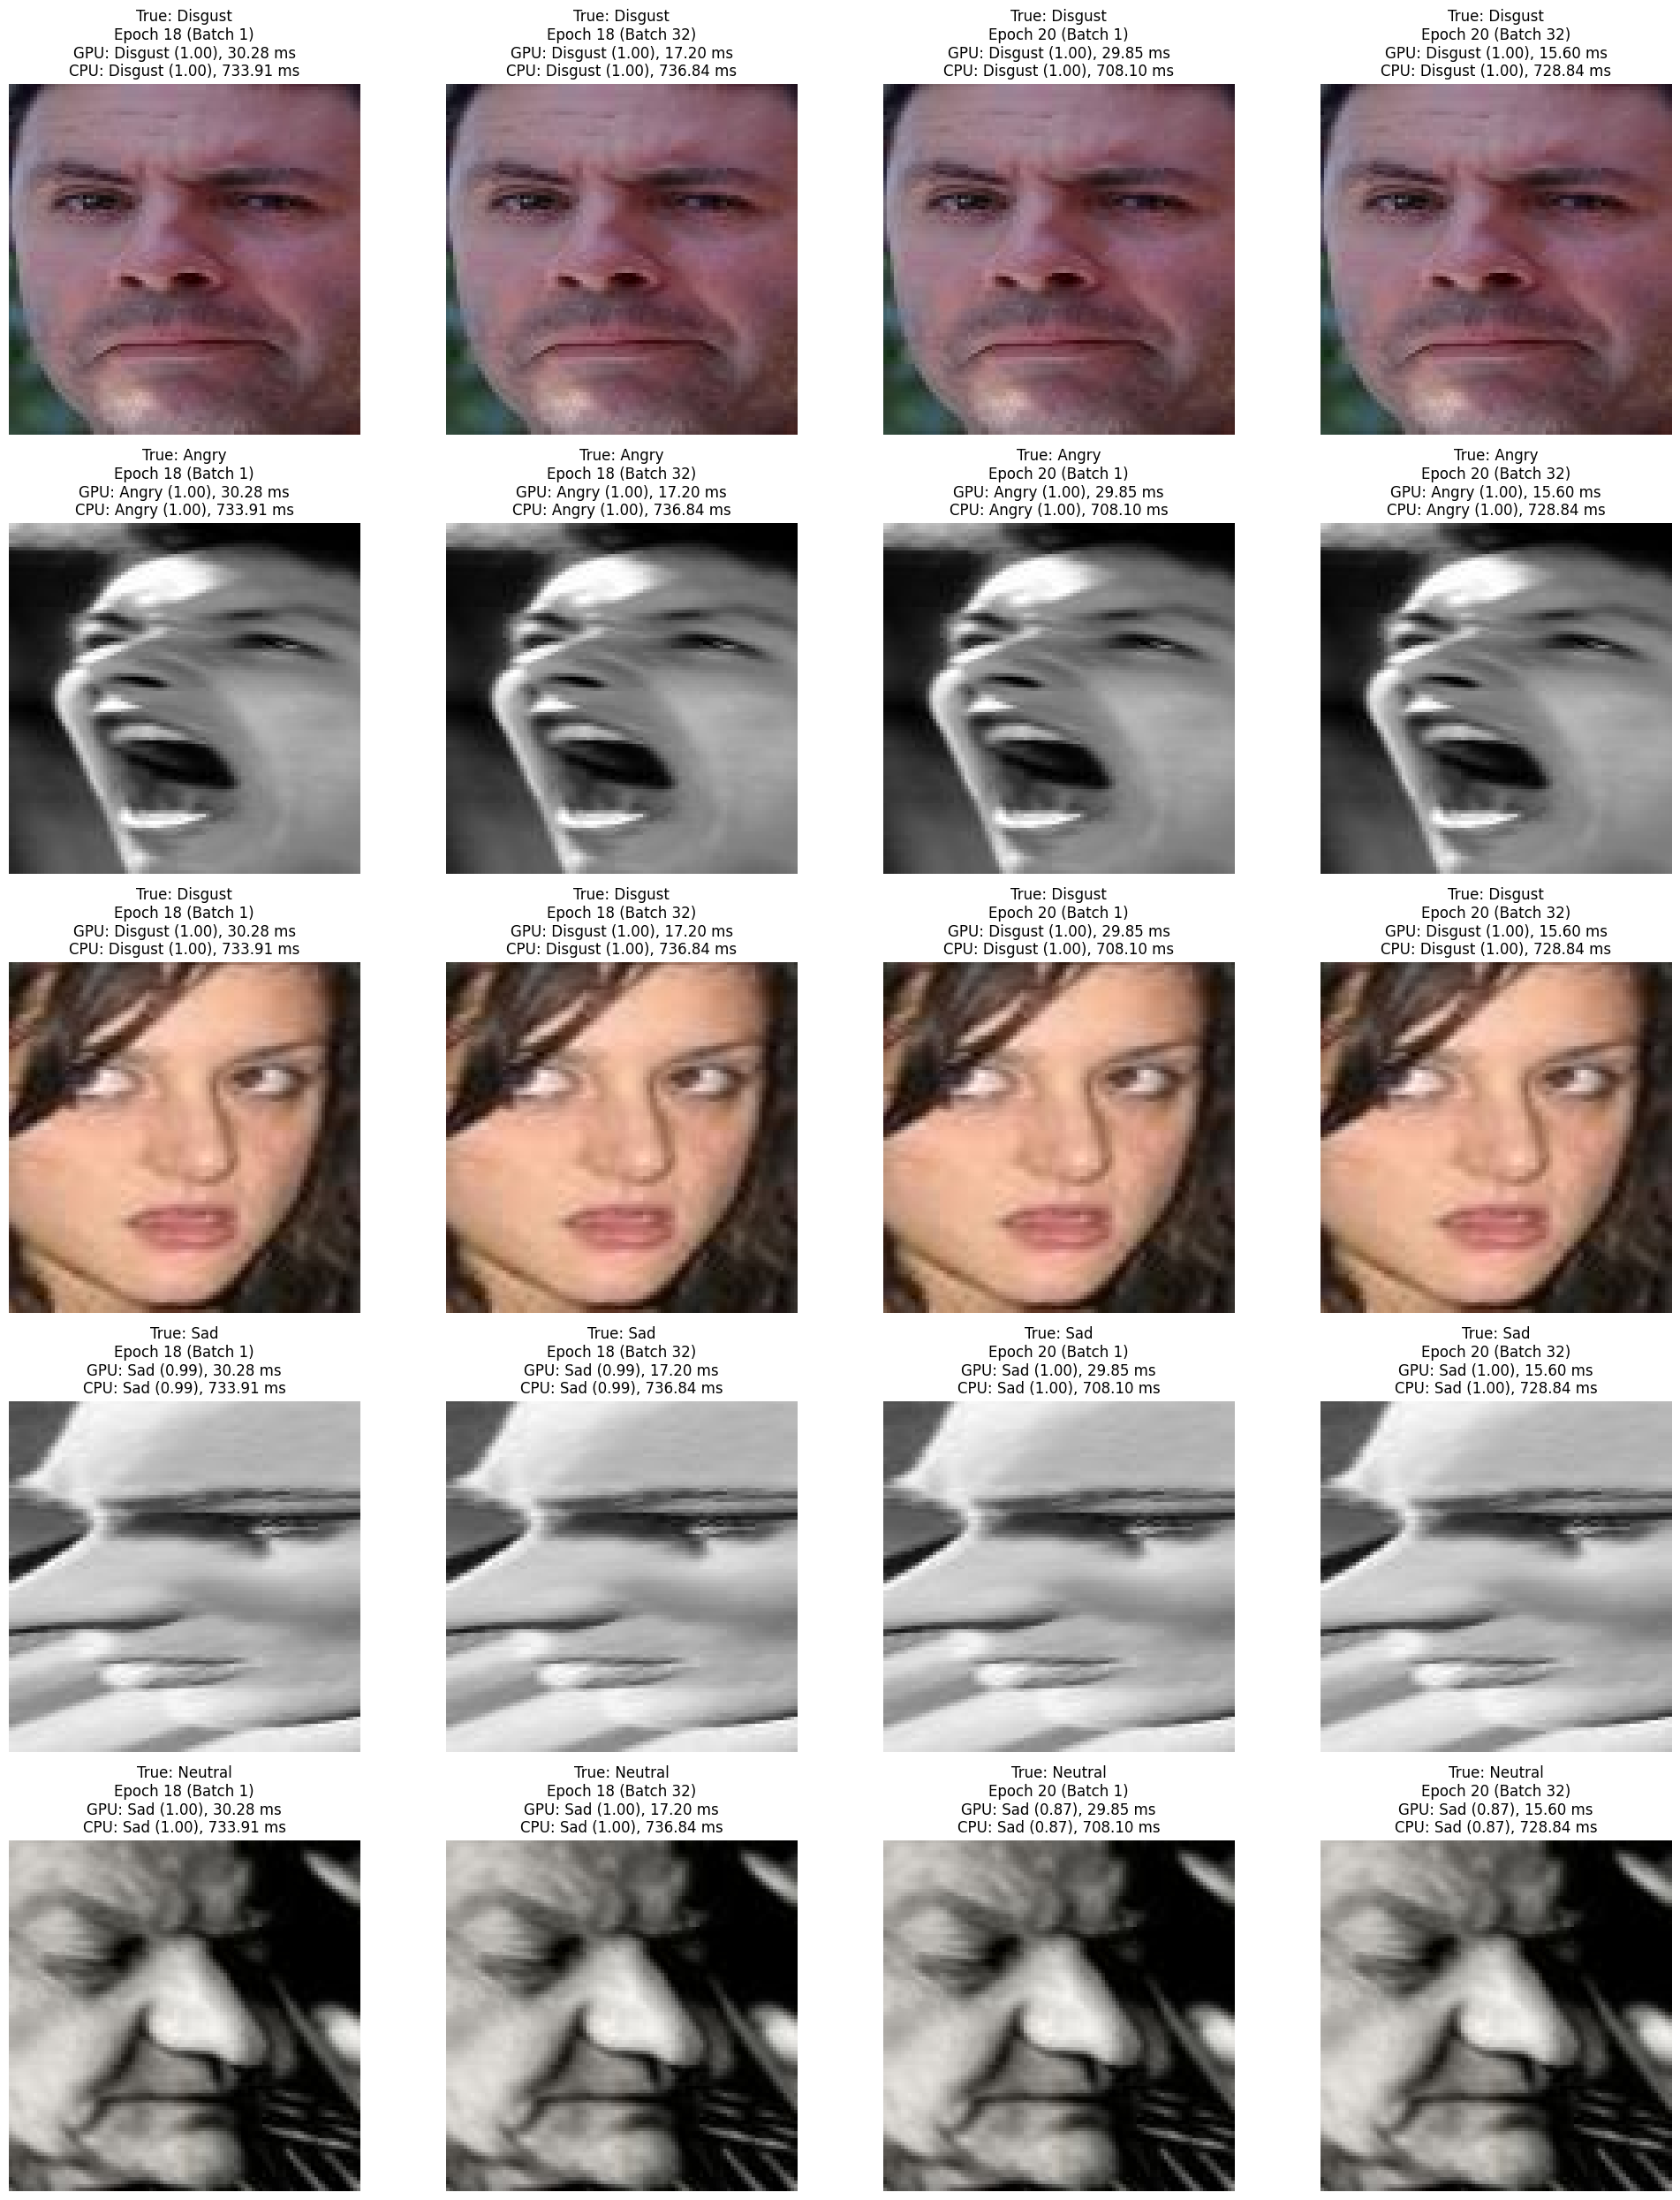

In [32]:
# Visualize inference results (first 5 images)
num_display = min(5, len(inference_image_paths))
fig, axes = plt.subplots(num_display, 4, figsize=(20, 5 * num_display))
for i in range(num_display):
    image_path = inference_image_paths[i]
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    true_label = class_names[label_map[inference_true_labels[i]]]

    # Epoch 18, Batch 1
    ax = axes[i, 0]
    pred_gpu, conf_gpu, lat_gpu = inference_results['Epoch 18'][1]['GPU']
    pred_cpu, conf_cpu, lat_cpu = inference_results['Epoch 18'][1]['CPU']
    ax.imshow(image_rgb)
    ax.set_title(f"True: {true_label}\nEpoch 18 (Batch 1)\nGPU: {pred_gpu[i]} ({conf_gpu[i]:.2f}), {lat_gpu:.2f} ms\nCPU: {pred_cpu[i]} ({conf_cpu[i]:.2f}), {lat_cpu:.2f} ms")
    ax.axis('off')

    # Epoch 18, Batch 32
    ax = axes[i, 1]
    pred_gpu, conf_gpu, lat_gpu = inference_results['Epoch 18'][32]['GPU']
    pred_cpu, conf_cpu, lat_cpu = inference_results['Epoch 18'][32]['CPU']
    ax.imshow(image_rgb)
    ax.set_title(f"True: {true_label}\nEpoch 18 (Batch 32)\nGPU: {pred_gpu[i]} ({conf_gpu[i]:.2f}), {lat_gpu:.2f} ms\nCPU: {pred_cpu[i]} ({conf_cpu[i]:.2f}), {lat_cpu:.2f} ms")
    ax.axis('off')

    # Epoch 20, Batch 1
    ax = axes[i, 2]
    pred_gpu, conf_gpu, lat_gpu = inference_results['Epoch 20'][1]['GPU']
    pred_cpu, conf_cpu, lat_cpu = inference_results['Epoch 20'][1]['CPU']
    ax.imshow(image_rgb)
    ax.set_title(f"True: {true_label}\nEpoch 20 (Batch 1)\nGPU: {pred_gpu[i]} ({conf_gpu[i]:.2f}), {lat_gpu:.2f} ms\nCPU: {pred_cpu[i]} ({conf_cpu[i]:.2f}), {lat_cpu:.2f} ms")
    ax.axis('off')

    # Epoch 20, Batch 32
    ax = axes[i, 3]
    pred_gpu, conf_gpu, lat_gpu = inference_results['Epoch 20'][32]['GPU']
    pred_cpu, conf_cpu, lat_cpu = inference_results['Epoch 20'][32]['CPU']
    ax.imshow(image_rgb)
    ax.set_title(f"True: {true_label}\nEpoch 20 (Batch 32)\nGPU: {pred_gpu[i]} ({conf_gpu[i]:.2f}), {lat_gpu:.2f} ms\nCPU: {pred_cpu[i]} ({conf_cpu[i]:.2f}), {lat_cpu:.2f} ms")
    ax.axis('off')

plt.tight_layout()
plt.show()